<center>

# <font color='#E95420'>Kaggle Challenge: "House Prices: Advanced Regression Techniques"</font>


## <font color='#77216F'>Project of "Fundamentals of Data Science" @ La Sapienza University of Rome</font>

## <font color='grey'>Team group: Michele Cernigliaro, Francesco Russo, Giuseppe Calabrese</font>

### <font color='darkgrey'>Academic Year: 2018/2019</font>

<img src="housesbanner.png">

<center>
<font color='black'>---------------------------------------------------------</font>
</center>

<center>
    
## <font color='#77216F'>0. Import data and modules</font>

In [1]:
# Import modules

import math
import numpy as np
import pandas as pd
import sklearn
import random

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import seaborn as sbn
import matplotlib.pyplot as plt
import datetime

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, pearsonr

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import train and test set

train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

# Save test Id column in a separate variable and drop it in the DataFrames

train.drop(columns = "Id", inplace = True)
test_id = test[["Id"]]
test.drop(columns = "Id", inplace = True)

<center>
<font color='black'>---------------------------------------------------------</font>
</center>

<center>
    
## <font color='#77216F'>1. Working with the variables and some data exploration</font>

<p>Excluding **Id** and **SalePrice** we have 79 features in our dataset.

We create two lists, one for numerical features and one for categorical features, in order to elaborate them separately.

We decided to migrate some features (**MoSold**, **YrSold**) from the numerical list to the categorical list, since it makes more sense to treat them as categorical.</p>

In [3]:
# Define numerical features

numerical_features = ["LotFrontage", "LotArea", "OverallQual",
                      "OverallCond", "YearBuilt", "YearRemodAdd", "MasVnrArea", "BsmtFinSF1",
                      "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
                      "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath",
                      "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
                      "Fireplaces", "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF",
                      "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea",
                      "MiscVal", "MoSold", "YrSold"]

# Removing MoSold and YrSold (putting them in categorical_features)

numerical_features.remove('MoSold')
numerical_features.remove('YrSold')

In [4]:
# Define categorical features

categorical_features = ["Alley", "MSZoning", "Street", "LotShape", "LandContour", "Utilities", 
                        "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", 
                        "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                        "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "MasVnrType",
                        "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", 
                        "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", 
                        "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", 
                        "MiscFeature", "SaleType", "SaleCondition"]

# Adding MoSold and YrSold to categorical_features

categorical_features.append('MoSold')
categorical_features.append('YrSold')

<center>
    
## <font color='darkgrey'>Features</font>

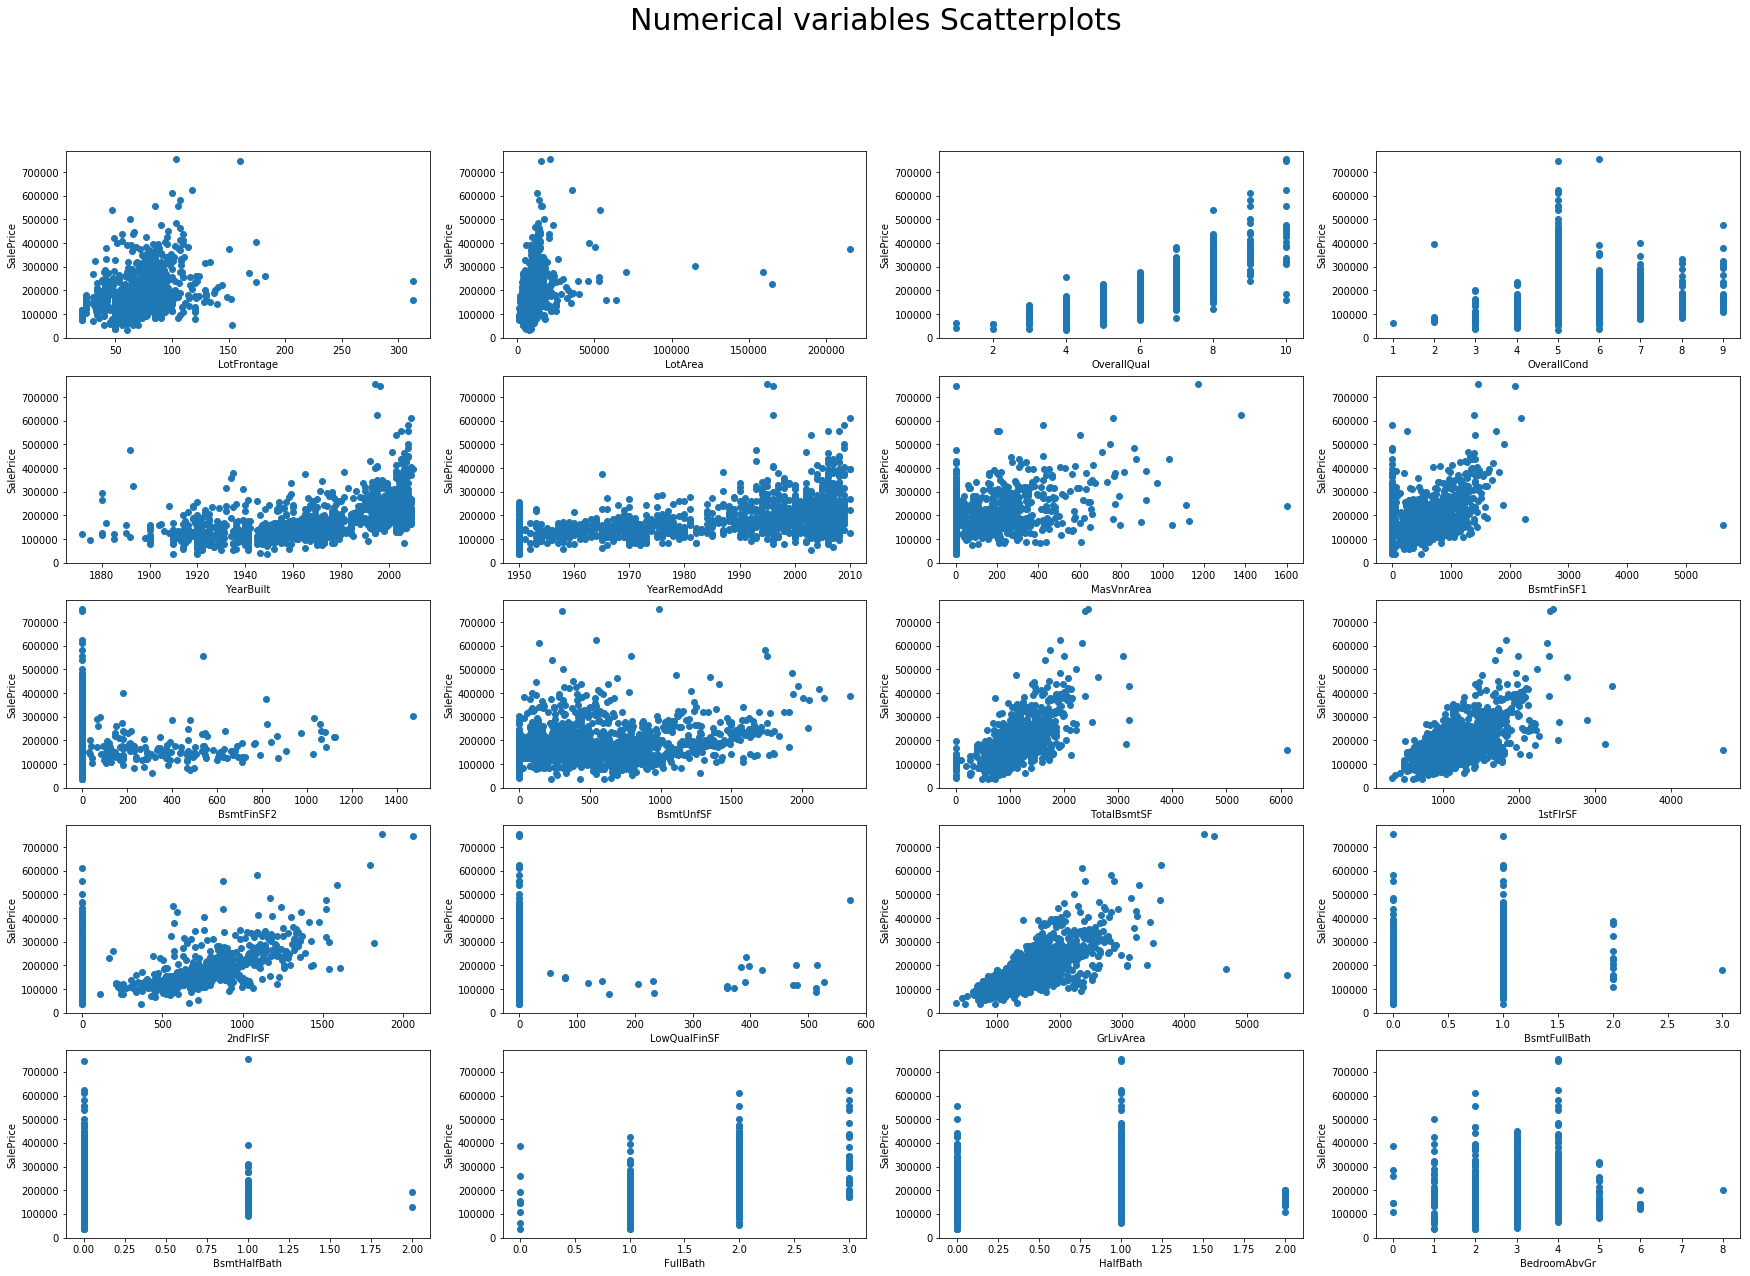

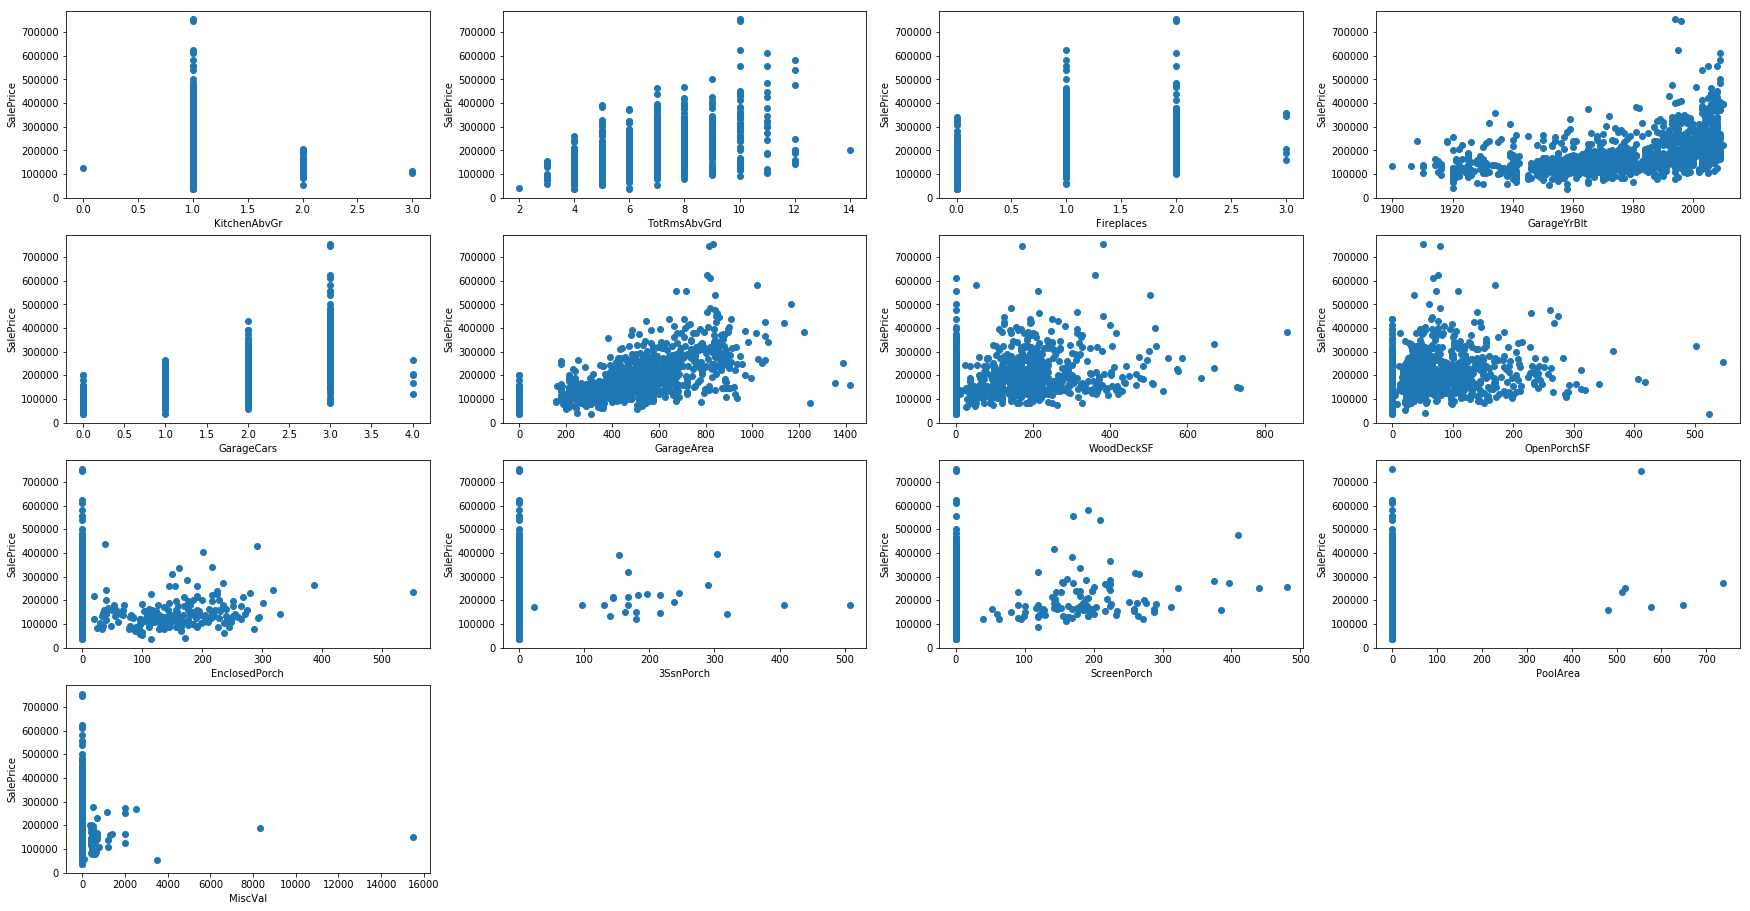

In [5]:
# scatterplots for numerical features

f = plt.figure(0, figsize=(30,20))
plots = []
cnt = 0
for i in range(5):
    for j in range(4):
        if cnt < 20:
            ax = plt.subplot2grid((5,4), (i,j))
            ax.scatter(x=numerical_features[cnt],y="SalePrice", data=train)
            ax.set_xlabel(numerical_features[cnt])
            ax.set_ylabel('SalePrice')
            cnt+=1

f.suptitle('Numerical variables Scatterplots', fontsize=30)
plt.show()

f = plt.figure(0, figsize=(30,20))
plots = []
for i in range(4):
    for j in range(4):
        if cnt < 33:
            ax = plt.subplot2grid((5,4), (i,j))
            ax.scatter(x=numerical_features[cnt],y="SalePrice", data=train)
            ax.set_xlabel(numerical_features[cnt])
            ax.set_ylabel('SalePrice')
            cnt+=1

plt.show()

We notice that there are some variables which are slightly correlated with the target variable. We can also observe that some numerical features could be handled as categorical. Therefore, to better understand them, we can try to show their boxplots.

In [6]:
# boxplot vars
box_vars = [ "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "BsmtFullBath",
             "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
             "Fireplaces", "GarageYrBlt", "GarageCars", "MoSold", "YrSold"]

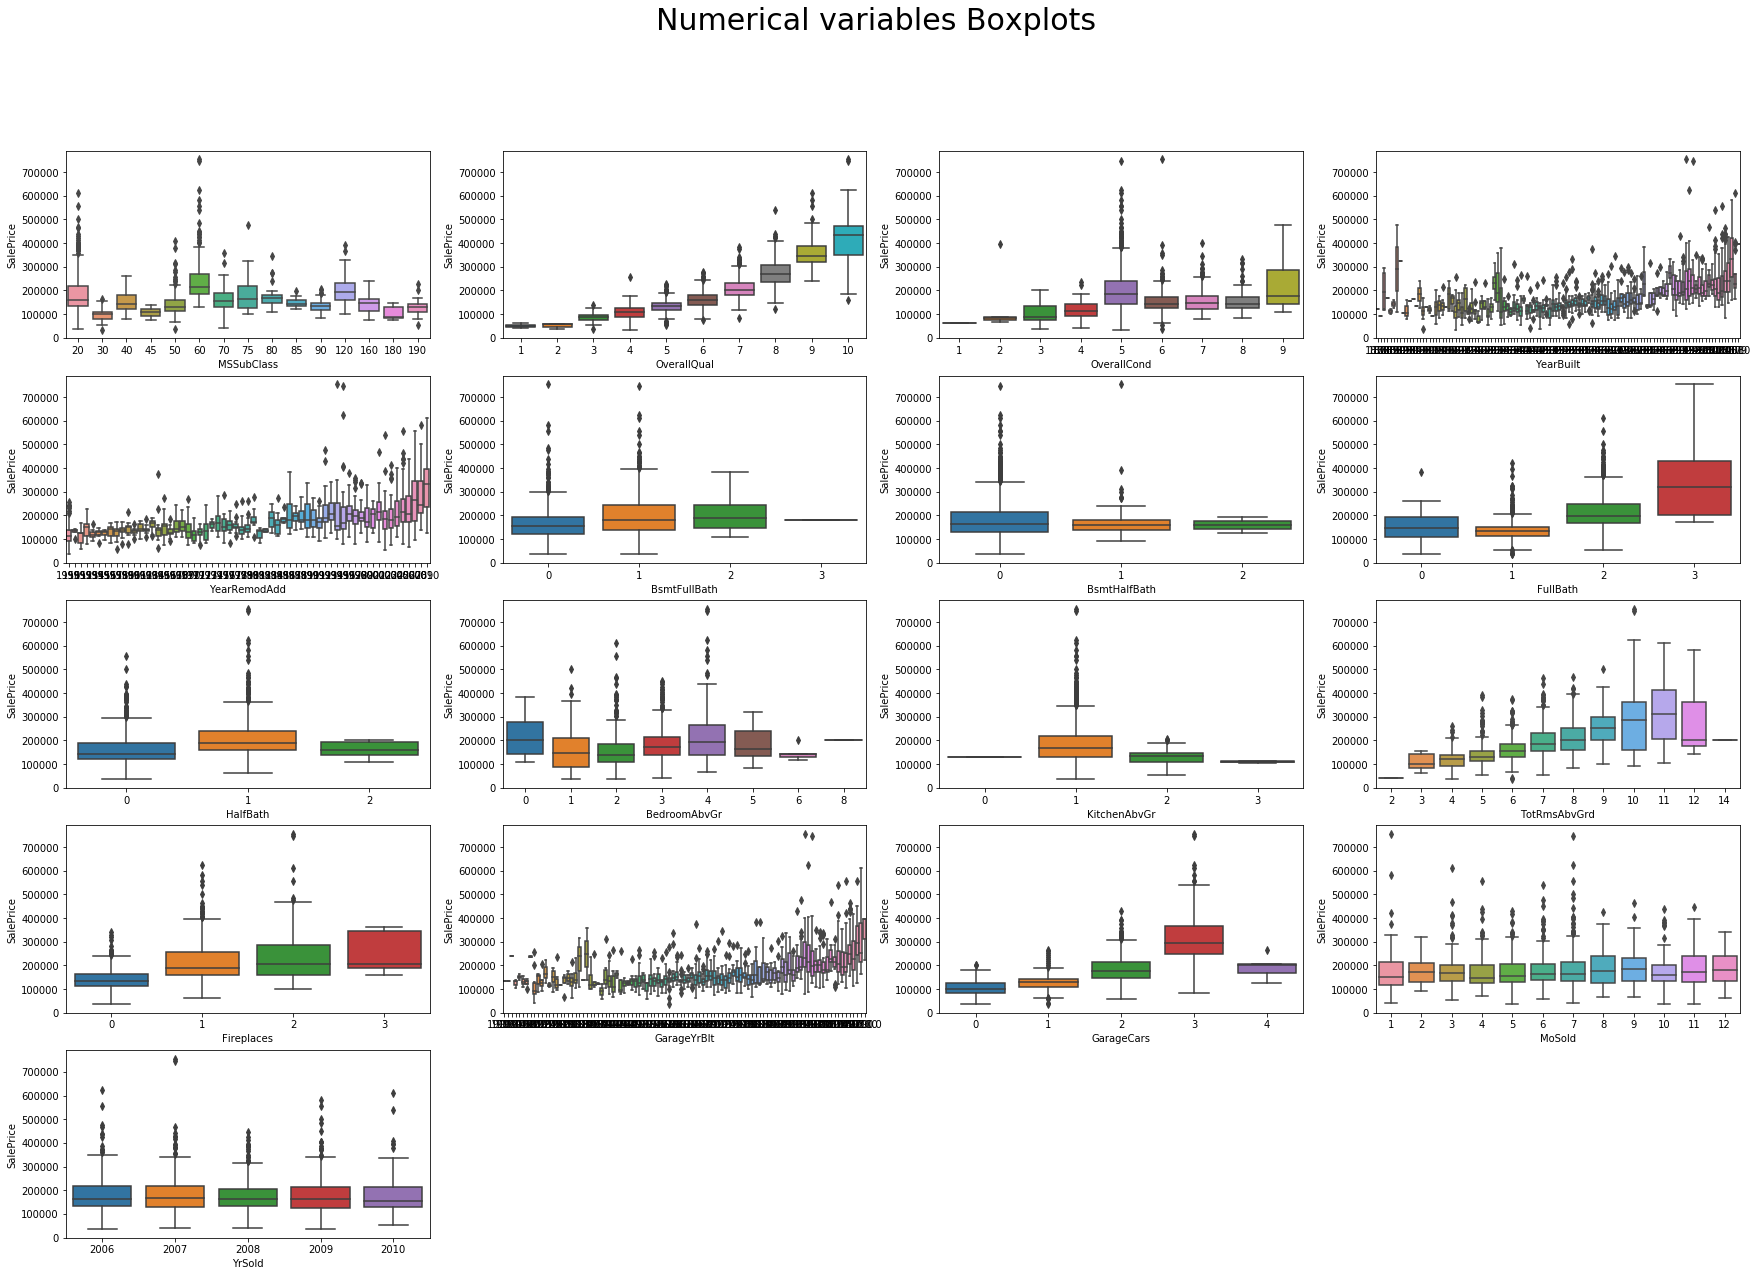

In [7]:
# other 20 features

f = plt.figure(0, figsize=(30,20))
cnt = 0
for i in range(5):
    for j in range(4):
        if cnt < 17:
            ax = plt.subplot2grid((5,4), (i,j))
            sbn.boxplot(x=box_vars[cnt],y="SalePrice", data=train)
            ax.set_xlabel(box_vars[cnt])
            cnt+=1

f.suptitle('Numerical variables Boxplots', fontsize=30)

plt.show()
plt.close()

As we can see, it makes more sense to treat them as categorical. However, treating them as numerical didn't affect our final result, so we decided to keep them as numerical features.

<center>
    
## <font color='darkgrey'>Target variable</font>

Text(0.5,0,'log(SalePrice)')

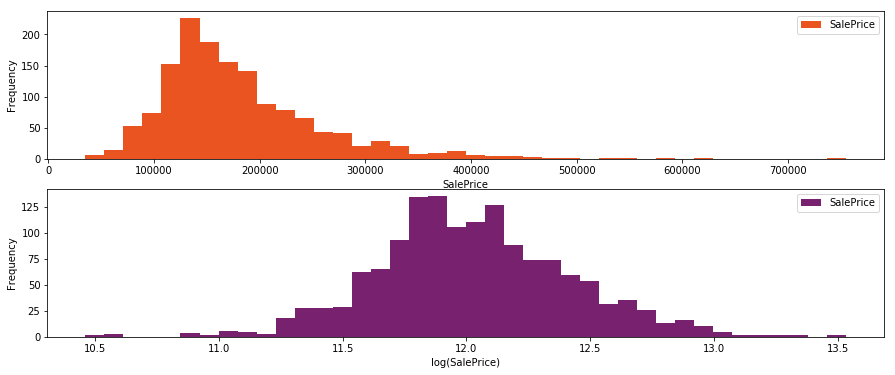

In [8]:
# Switch to logarithmic price in order to avoid negative prices in the prediction
# We can see that after the transformation the label SalePrice is normally distributed, as we want

# plotting SalePrice distribution
fig, (ax1, ax2) = plt.subplots(2,1)
train[["SalePrice"]].plot(kind = "hist",ax=ax1, color = "#E95420", bins = 40, figsize = (15, 6))
ax1.set_xlabel('SalePrice')

# log transofmation to SalePrice
train["SalePrice"] = train["SalePrice"].apply(math.log1p)

# plotting log(SalePrice) distribution
train[["SalePrice"]].plot(kind = "hist", ax=ax2, color = "#77216F", bins = 40, figsize = (15, 6))
ax2.set_xlabel('log(SalePrice)')

<center>
<font color='black'>---------------------------------------------------------</font>
</center>

<center>
    
## <font color='#77216F'>2. Missing values</font>

</center>
We decided to impute NaNs using three different strategies:

1. Impute mean (numerical variables)
2. Impute mode (categorical variables)
3. Impute median w.r.t. ***Neighborhood*** (for some numerical variables)

We also decided to drop **Street** and **Utilities**, because in both cases, the observations assume mainly one value.

In [9]:
# Imputing NaNs grouping for neighborhoods for LotFrontage, LotArea, YearBuilt

LotFrontage_medians = train.groupby('Neighborhood')['LotFrontage'].median().to_dict()

LotFr_keys   = train[train.LotFrontage.isna()].Neighborhood.values
null_indices = train[train.LotFrontage.isna()].index

for key_idx, df_idx in enumerate(null_indices):
    train.loc[df_idx,'LotFrontage'] = LotFrontage_medians[LotFr_keys[key_idx]]
    
LotArea_medians = train.groupby('Neighborhood')['LotArea'].median().to_dict()

LotArea_keys   = train[train.LotArea.isna()].Neighborhood.values
null_indices = train[train.LotArea.isna()].index

for key_idx, df_idx in enumerate(null_indices):
    train.loc[df_idx,'LotArea'] = LotArea_medians[LotArea_keys[key_idx]]

    
YearBuilt_medians = train.groupby('Neighborhood')['YearBuilt'].median().to_dict()

YearBuilt_keys   = train[train.YearBuilt.isna()].Neighborhood.values
null_indices = train[train.YearBuilt.isna()].index

for key_idx, df_idx in enumerate(null_indices):
    train.loc[df_idx,'YearBuilt'] = YearBuilt_medians[YearBuilt_keys[key_idx]]

In [10]:
# Impute mean to fill NaNs

for feature in numerical_features:
    train[feature] = train[feature].fillna(np.mean(train[feature]))
    test[feature] = test[feature].fillna(np.mean(test[feature]))

In [11]:
# Drop Street and Utilites

train.drop(['Street', 'Utilities'], axis = 1, inplace=True)
test.drop(['Street', 'Utilities'], axis = 1, inplace=True)

In [12]:
# Imputing mode to fill NaNs

def mode(series):
    lst = [value for value in series if type(value) != float]
    return max(set(lst), key = lst.count)

categorical_features.remove('Street')
categorical_features.remove('Utilities')

for feature in categorical_features:
    train[feature] = train[feature].fillna(mode(train[feature]))
    test[feature] = test[feature].fillna(mode(test[feature]))

<center>
<font color='black'>---------------------------------------------------------</font>
</center>

<center>
    <h2><font color='#77216F'>3. Feature engineering</font></h2>
</center>

We applied the following steps:

* A logarithmic transformation to all the features having a skewness greater than $0.5$
* We created a new feature (**TotBaths**)
* We extrapolated boolean variables out of some categorical variables.

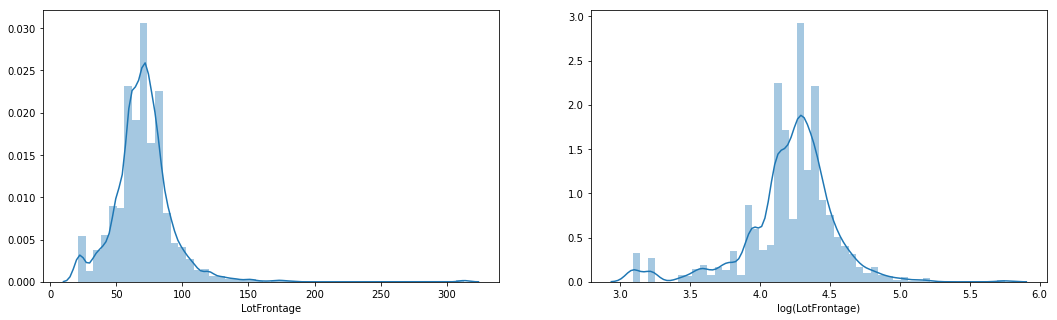

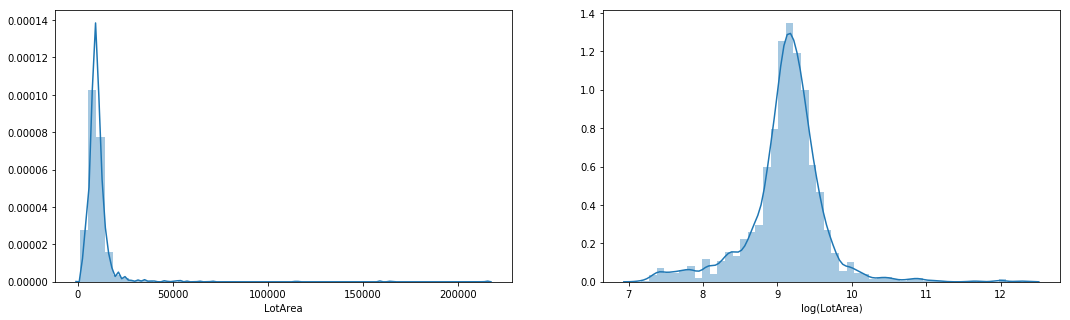

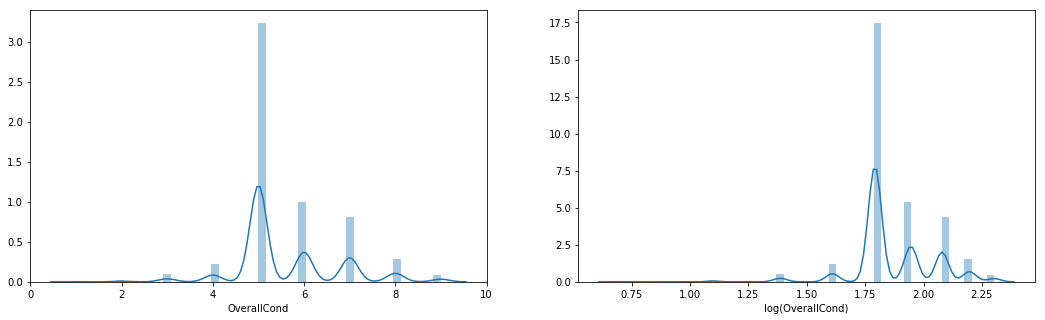

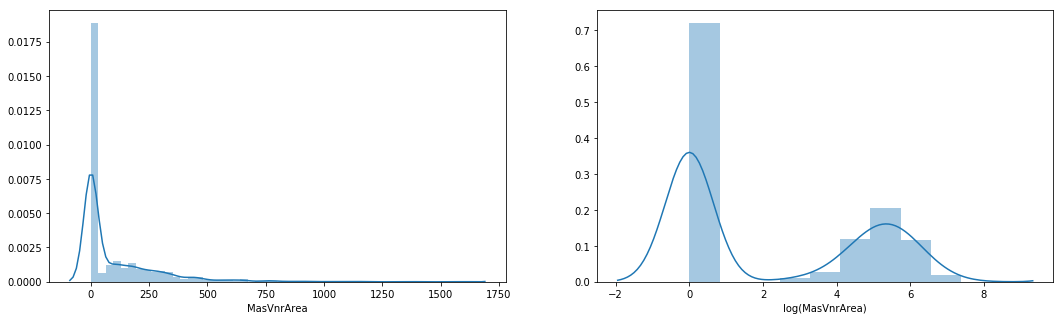

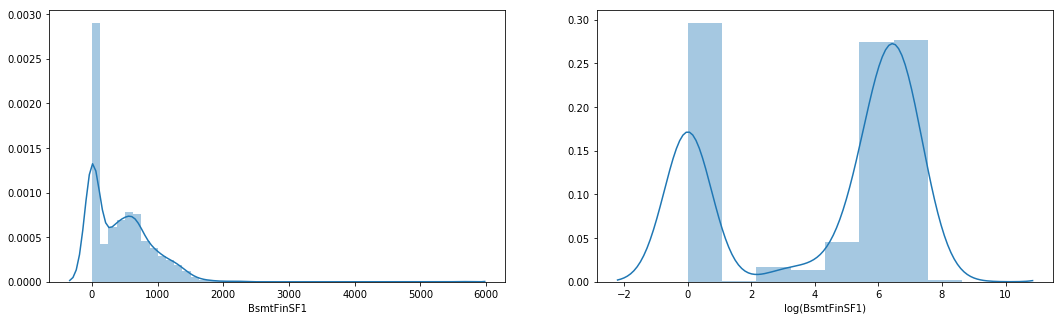

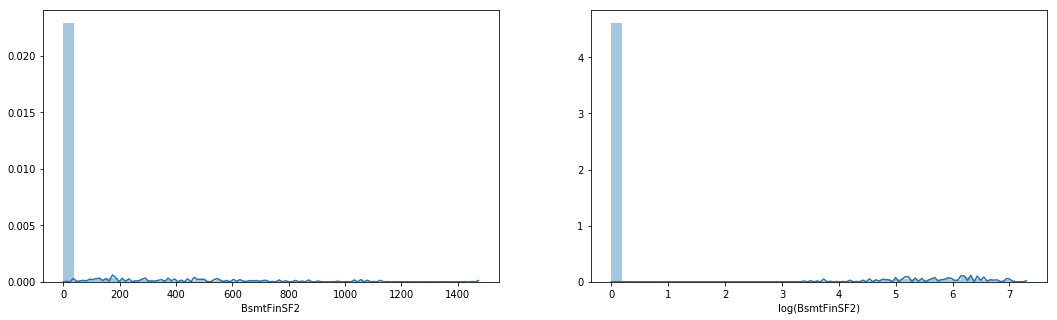

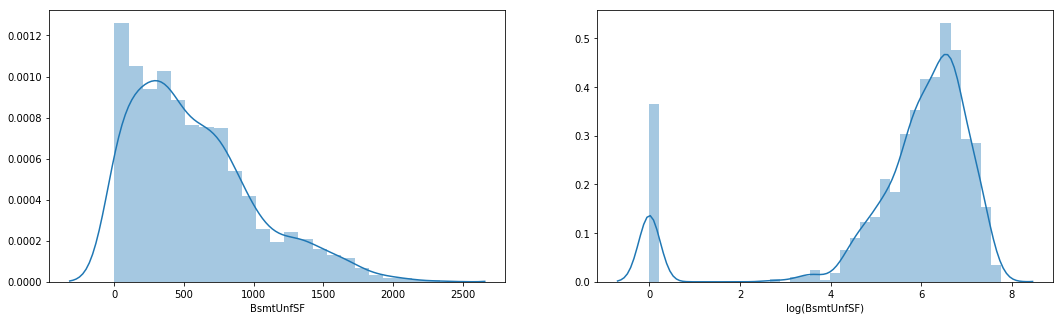

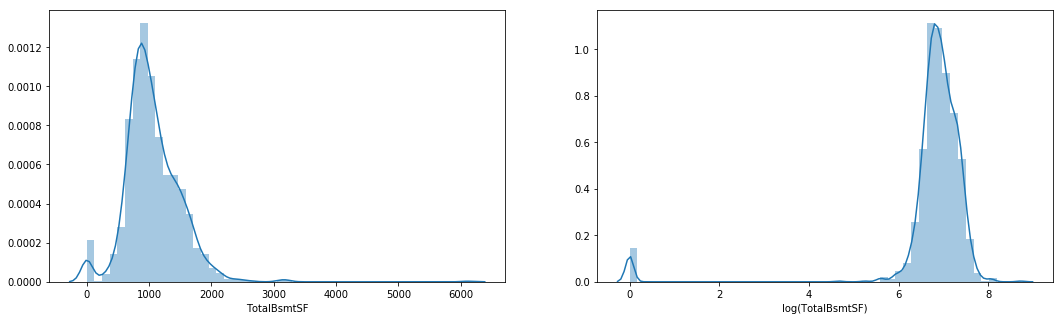

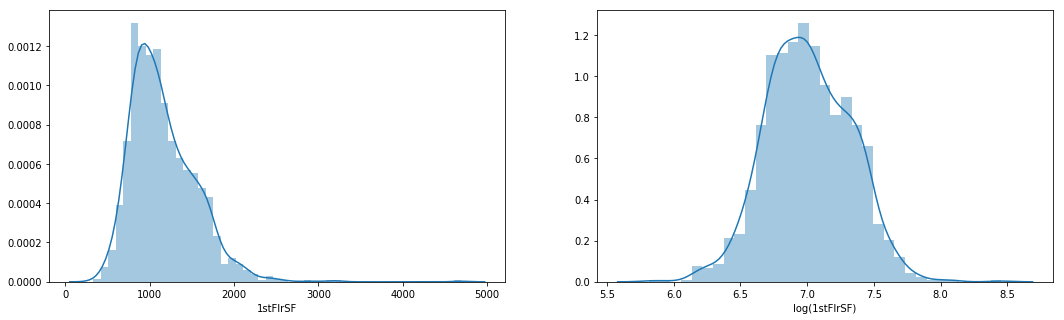

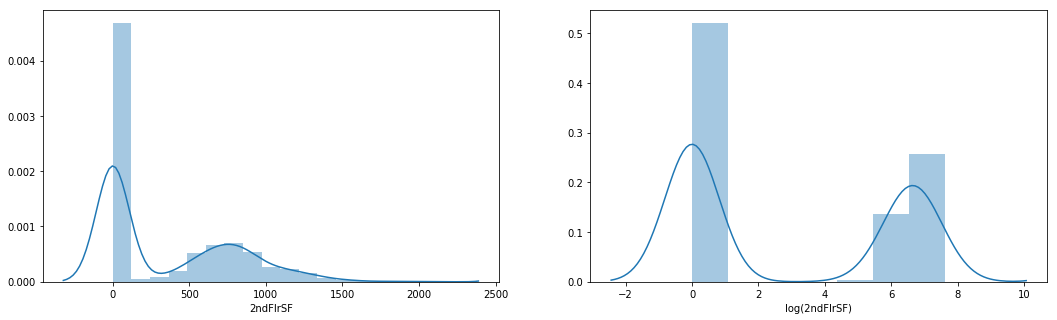

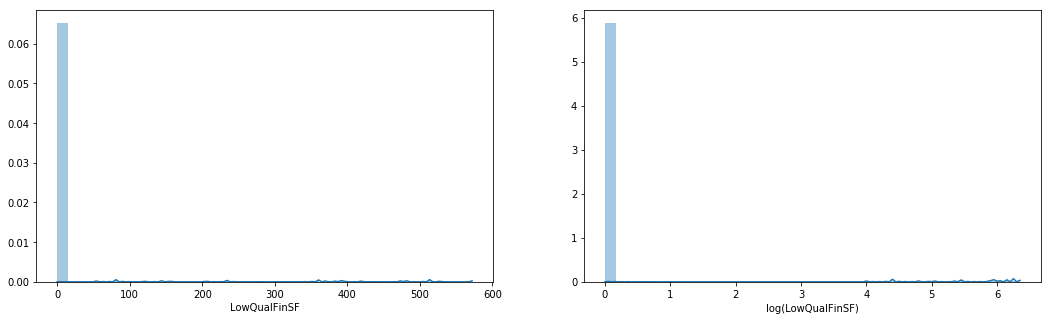

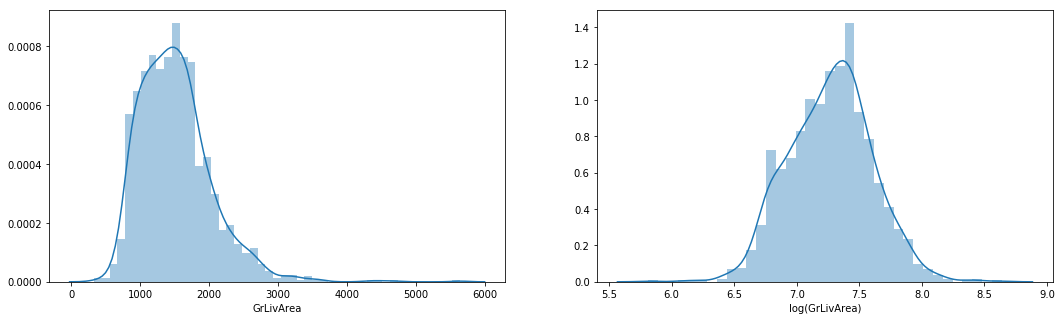

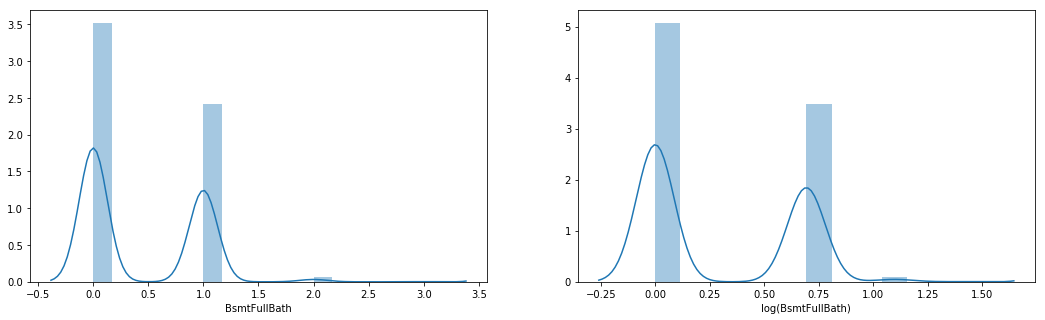

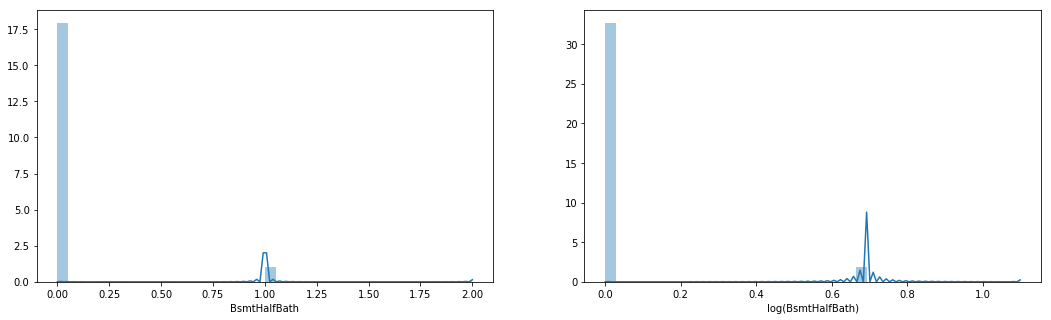

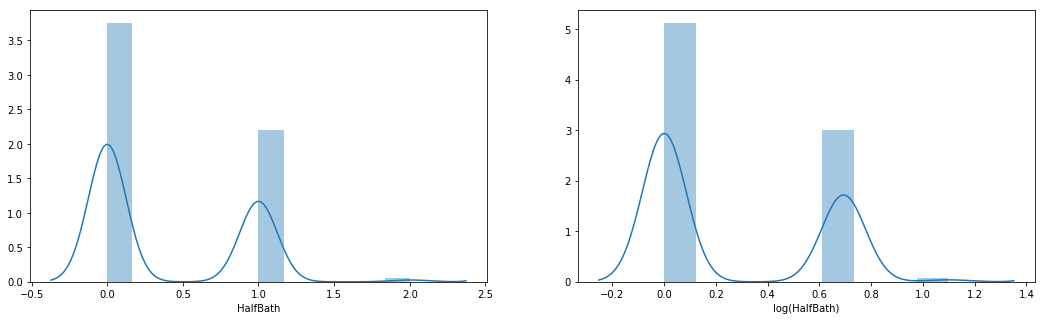

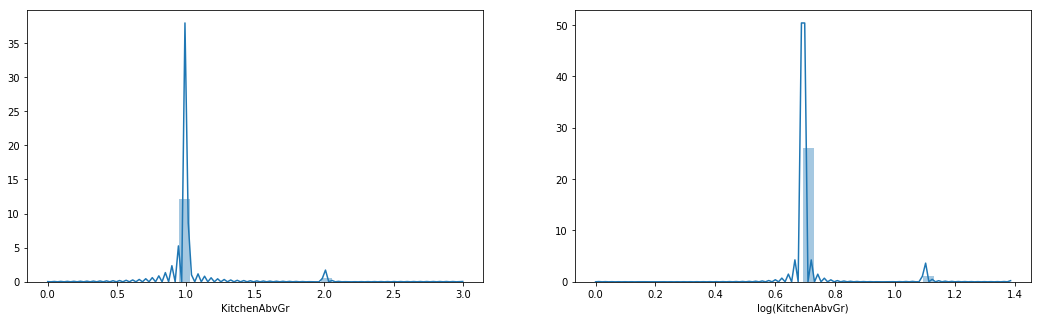

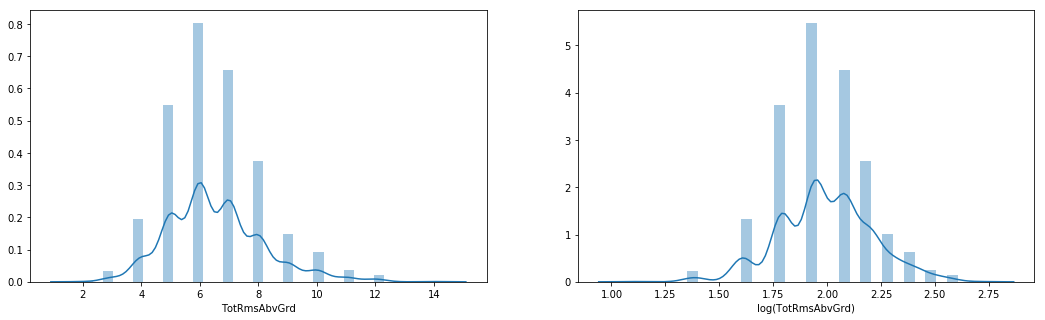

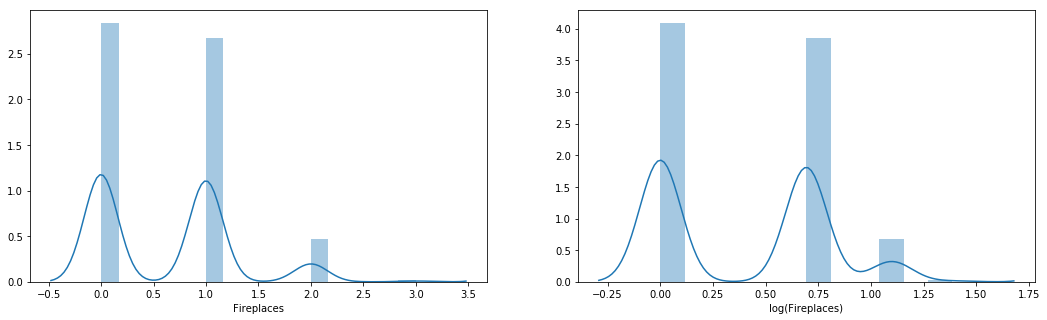

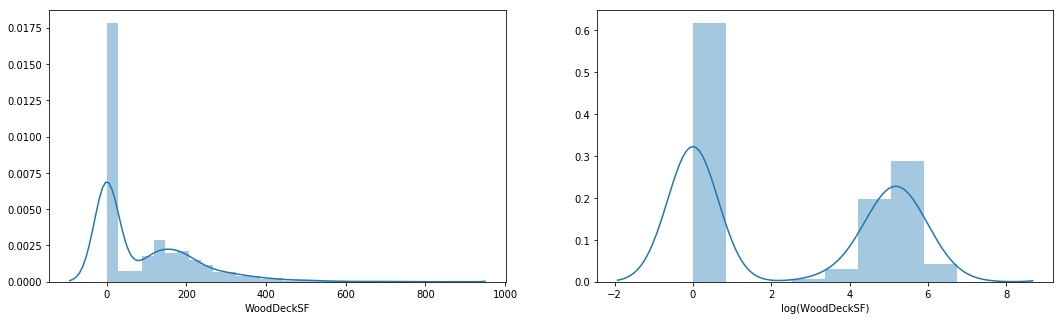

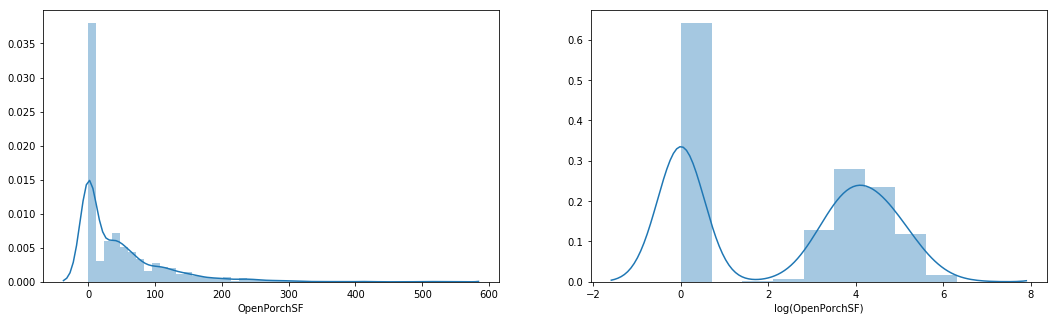

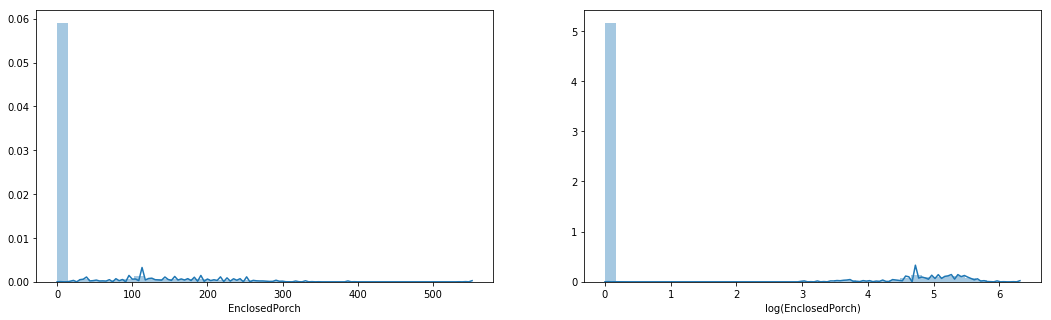

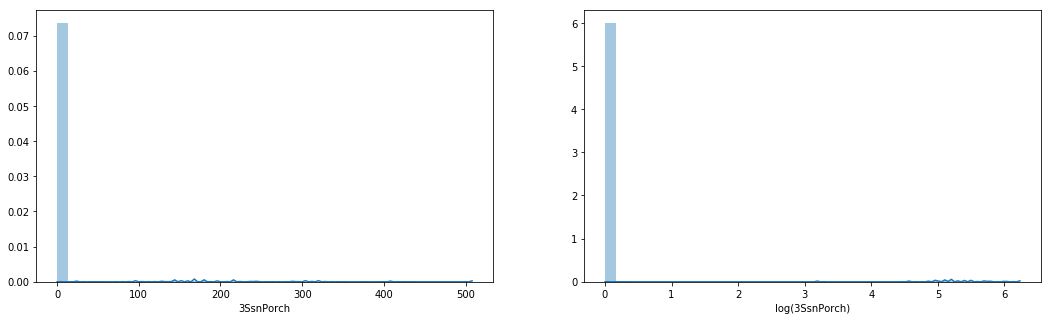

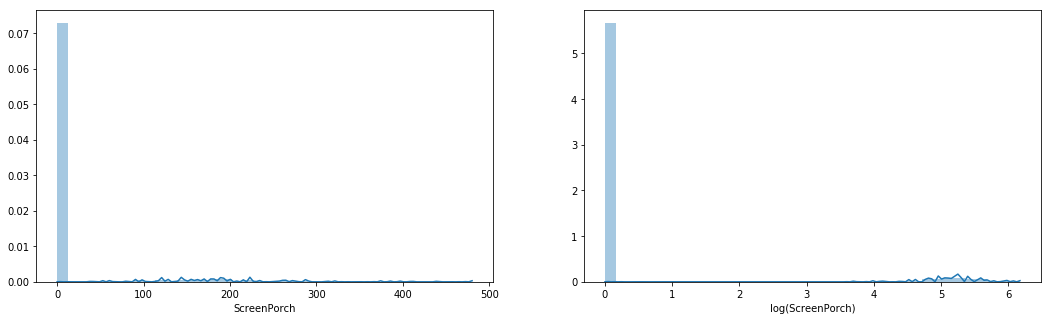

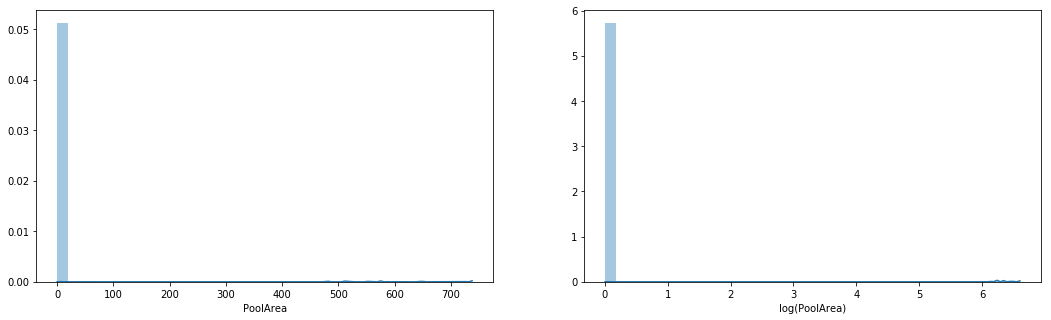

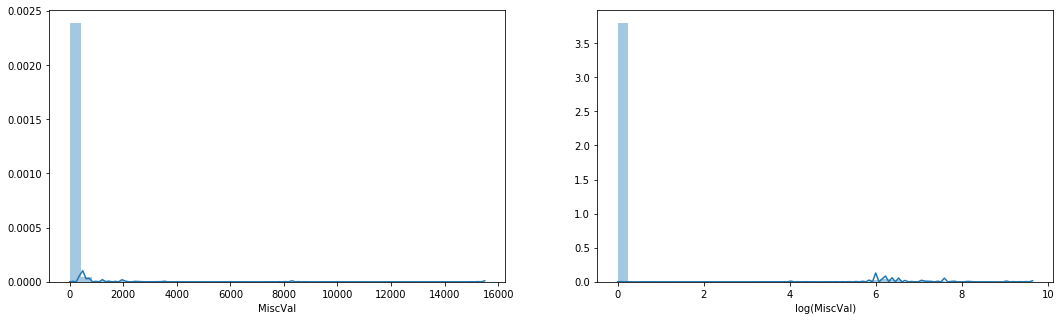

In [13]:
# Using np.log1p

for feature in numerical_features:
    if skew(train[feature]) > 0.5:
        
        # creating two plots
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
        
        # feature distribution plot before log-transform
        sbn.distplot(train[feature], ax=ax1, label=feature)
        
        # log-transform for feature values (both train and test set)
        train[feature] = train[feature].apply(np.log1p)
        test[feature] = test[feature].apply(np.log1p)

        # feature distribution after log-transform
        sbn.distplot(train[feature], ax=ax2, label= "log(" + feature + ")")
        
        # set x labels
        ax1.set_xlabel(feature)
        ax2.set_xlabel("log(" + feature + ")")

<center>
    
## <font color='darkgrey'>Rooms features</font>

We found out that, out of all the room-related features, only **FullBath** and **TotRoomsAbvGrd** have a reasonably high correlation with the **SalePrice**. We can see it showing an heatmap: 

In [14]:
# taking all rooms feature from TRAINING SET (we need SalePrice)
rooms = pd.DataFrame(data=train, columns=["BsmtFullBath", "BsmtHalfBath",
                                             "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",
                                             "TotRmsAbvGrd", "SalePrice"])

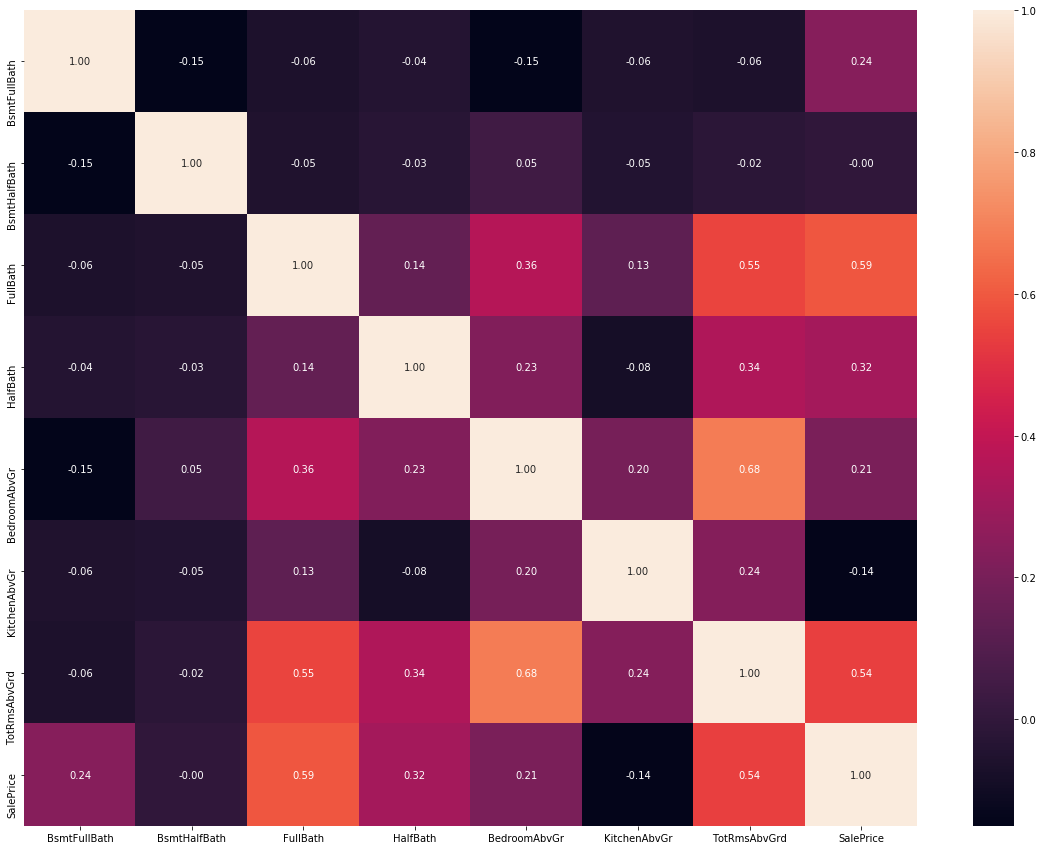

In [15]:
f, ax = plt.subplots(figsize=(20, 15))
sbn.heatmap(rooms.corr(),annot=True, fmt=".2f")

We can try to increase the correlation with the **SalePrice** creating two new features: **TotBaths** and **TotRooms**.

In [16]:
rooms.drop(["SalePrice"],axis=1, inplace=True)
rooms["TotBaths"] = rooms.BsmtFullBath + rooms.BsmtHalfBath + rooms.HalfBath + rooms.FullBath


#TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
rooms["TotRooms"] = rooms.TotRmsAbvGrd + rooms.TotBaths

rooms.drop(["BsmtFullBath", "BsmtHalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
            "FullBath", "HalfBath"], axis=1, inplace=True)
rooms["SalePrice"] = train.SalePrice

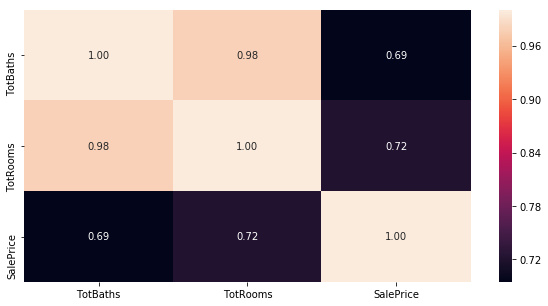

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
sbn.heatmap(rooms.corr(),annot=True, fmt=".2f")

The two new variables increase the correlation with the target one, which is a good thing. However TotBaths and TotRooms are highly correlated with each other, because the latter is a linear function of the former. Thus, since they have similar correlation with the target, we decided to keep ***TotBaths***.

In [18]:
# free up some memory
del(rooms)

In [19]:
# Creating new features

# TotBaths
train["TotBaths"] = train.BsmtFullBath + train.BsmtHalfBath + train.HalfBath + train.FullBath
test["TotBaths"] = test.BsmtFullBath + test.BsmtHalfBath + test.HalfBath + test.FullBath


# Boolean features

train['PoolBoolean'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['2ndFlrSFBoolean'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['GarageAreaBoolean'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['TotalBsmtSFBoolean'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['FireplacesBoolean'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

test['PoolBoolean'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['2ndFlrSFBoolean'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['GarageAreaBoolean'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test['TotalBsmtSFBoolean'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['FireplacesBoolean'] = test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

<center>
<font color='black'>---------------------------------------------------------</font>
</center>

<center> 
<h2><font color='#77216F'>4. One Hot Encoding</font></h2>
</center>

We tried to use Label Encoding where it was appropriate, but the results were quite poor, so in the end we decided to limit ourselves to One Hot Encoding.
In order to apply One Hot Encoding, we merge the train and test datasets so that in all the features we cover all the possible values.

In [20]:
# Using a temporary variable for SalePrice

saleprice = train['SalePrice']
train_len = len(train)

# Merging the datasets and applying One Hot Encoding using get_dummies()

all_data = pd.concat([train.drop(columns=['SalePrice']), test])
all_data = pd.get_dummies(all_data, prefix_sep='')

# Splitting again

train = all_data.iloc[0:train_len]
train['SalePrice'] = saleprice
test = all_data.iloc[train_len:]

# free up some memory
del(all_data)

We get rid of all the observations in the training set, having a value of **GrLivArea** greater than $4500$, since they are outliers and therefore misleading for the sake of our analysis.

In [21]:
# Removing observations

train = train[train.GrLivArea < 4500]

One Hot Encoding produces a lot of binary features, which can therefore assume values {0,1}. This means that we can encounter features whose values are mostly 0's. We decided to remove columns with more than 99,2% of 0's.

In [22]:
# Removing columns with 99.2% of zeros

for feature in train.columns:
    counts = train[feature].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 99.2:
        train.drop([feature], axis=1, inplace=True)
        test.drop([feature], axis=1, inplace=True)

<center>
<font color='black'>---------------------------------------------------------</font>
</center>

<center> 
<h2><font color='#77216F'>5. Managing multicollinearity</font></h2>
</center>

First of all, we check the correlation between the numerical Garage-like features, and the **SalePrice**.

In [23]:
garages = ['GarageArea', 'GarageCars', 'GarageYrBlt', 'SalePrice']
pd.DataFrame(train, columns=garages).corr()

,GarageArea,GarageCars,GarageYrBlt,SalePrice
GarageArea,1.000000,0.882475,0.476498,0.650888
GarageCars,0.882475,1.000000,0.482534,0.680625
GarageYrBlt,0.476498,0.482534,1.000000,0.500449
SalePrice,0.650888,0.680625,0.500449,1.000000


As we can see, **GarageArea** and **GarageCars** are highly correlated with each other and with the **SalePrice**, thus we remove **GarageArea**, which has the lowest correlation with the response variable.

In [24]:
def plotscatter(feature1, feature2):
    """
    function which makes 2 regression plots: 
    feature1 vs SalePrice
    feature2 vs SalePrice
    """
    fig = plt.figure(figsize = (15,6))

    sbn.regplot(x = train[feature1], y = train.SalePrice,
               scatter_kws={"color": "blue"}, line_kws={"color": "orange"})

    fig = plt.figure(figsize = (15,6))

    sbn.regplot(x = train[feature2], y = train.SalePrice,
               scatter_kws={"color": "blue"}, line_kws={"color": "orange"})
    
    return

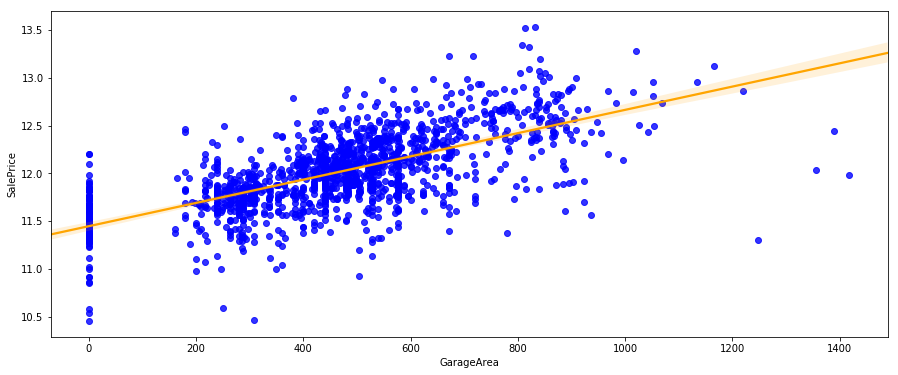

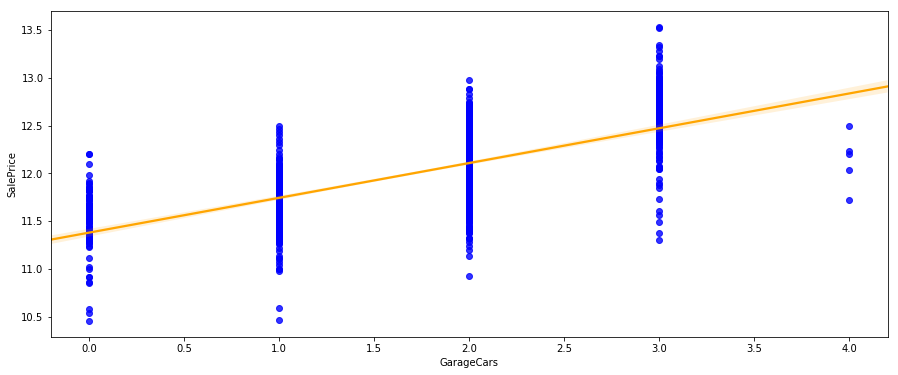

In [25]:
plotscatter("GarageArea", "GarageCars")

In [26]:
train.drop(columns=['GarageArea'], inplace=True)
test.drop(columns=['GarageArea'], inplace=True)

We decide to proceed with a pairwise correlation analysis. More specifically, we define a function which returns the two couples of variables having the highest positive and negative mutual correlation, respectively.
Then we use another function to compare the two features in each couple (maximum positive or negative correlation) with the SalePrice.

In [27]:
# Define return_max_correlation function

def return_max_correlations(train):
    '''
    This function takes the training dataframe, and returns the "ret" dictionary
    Input: Pandas dataframe
    Output: Dictionary of the form: 
            
    "ret" = {
              positive correlation: ["correlated features list", "correlation coefficient"]
              negative correlation: ["correlated features list", "correlation coefficient"]
            }

    '''
    
    corr = train.corr()

    score_neg = 0
    pos = 'none'
    score_pos = 0
    neg = 'none'
    corr.values[[np.arange(corr.shape[0])]*2] = 0

    for col in corr.columns:
        for i in range(len(corr)):
            temp = corr.iloc[i][col]
            if temp > 0:
                if temp > score_pos:
                    score_pos = temp
                    pos = [col, corr.index[i]]

            if temp < 0:
                if temp < score_neg:
                    score_neg = temp
                    neg = [col, corr.index[i]]
               
    ret = {'pos_corr': [pos, score_pos],
           'neg_corr': [neg, score_neg]}
    
    return ret

# Define compare_correlation_with_SalePrice

def compare_correlation_with_SalePrice(items):
    '''
    This function returns a dataframe containing the correlation matrix 
    of the variables (from the training set) which we pass to it together with the SalePrice.
    Input: list of features
    Output: correlation matrix (in a dataframe)
    '''
    
    cols = items + ['SalePrice']
    temp = pd.DataFrame(train, columns=cols)
    
    return temp.corr()

In [28]:
correlations = return_max_correlations(train)
correlations

{'pos_corr': [['2ndFlrSF', '2ndFlrSFBoolean'], 0.9973335325307368],
 'neg_corr': [['AlleyGrvl', 'AlleyPave'], -1.0]}

In [29]:
compare_correlation_with_SalePrice(correlations['pos_corr'][0])

,2ndFlrSF,2ndFlrSFBoolean,SalePrice
2ndFlrSF,1.000000,0.997334,0.180778
2ndFlrSFBoolean,0.997334,1.000000,0.150549
SalePrice,0.180778,0.150549,1.000000


In [30]:
# Remove 2ndFlrSFBoolean since it has less correlation

train.drop(columns=['2ndFlrSFBoolean'], inplace=True)
test.drop(columns=['2ndFlrSFBoolean'], inplace=True)

In [31]:
compare_correlation_with_SalePrice(correlations['neg_corr'][0])

,AlleyGrvl,AlleyPave,SalePrice
AlleyGrvl,1.000000,-1.000000,0.011595
AlleyPave,-1.000000,1.000000,-0.011595
SalePrice,0.011595,-0.011595,1.000000


In [32]:
# Remove AlleyPave since it has less correlation

train.drop(columns=['AlleyPave'], inplace=True)
test.drop(columns=['AlleyPave'], inplace=True)

In [33]:
correlations = return_max_correlations(train)
correlations

{'pos_corr': [['SaleTypeNew', 'SaleConditionPartial'], 0.9868189596845469],
 'neg_corr': [['CentralAirN', 'CentralAirY'], -1.0]}

In [34]:
compare_correlation_with_SalePrice(correlations['pos_corr'][0])

,SaleTypeNew,SaleConditionPartial,SalePrice
SaleTypeNew,1.000000,0.986819,0.329190
SaleConditionPartial,0.986819,1.000000,0.324471
SalePrice,0.329190,0.324471,1.000000


In [35]:
# Remove SaleConditionPartial since it has less correlation

train.drop(columns=['SaleConditionPartial'], inplace=True)
test.drop(columns=['SaleConditionPartial'], inplace=True)

In [36]:
compare_correlation_with_SalePrice(correlations['neg_corr'][0])

,CentralAirN,CentralAirY,SalePrice
CentralAirN,1.000000,-1.000000,-0.351599
CentralAirY,-1.000000,1.000000,0.351599
SalePrice,-0.351599,0.351599,1.000000


In [37]:
# Remove CentralAirN

train.drop(columns=['CentralAirN'], inplace=True)
test.drop(columns=['CentralAirN'], inplace=True)

Proceeding iteratively in this way, we ended up removing the following features: 

In [38]:
to_remove = ['BsmtFinType2GLQ', 'BsmtFinSF1', 'MasVnrTypeBrkCmn', 'Fireplaces', 'TotalBsmtSFBoolean', 
             'MSZoningRL', 'ExterQualGd', 'Exterior2ndCmentBd', 'Exterior2ndHdBoard', 'TotRmsAbvGrd']

In [39]:
train.drop(columns = to_remove, inplace = True)
test.drop(columns = to_remove, inplace = True)

In [40]:
train.shape

(1460, 198)

<center>
    <h2><font color='#77216F'>6. Feature Selection using Xgboost</font></h2>
</center>

As we can see above, we ended up with 198 features. 

Now, we decided to use Xgboost (XGBRegressor) to further filter out less important features. Indeed, XGBRegressor Model has as attribute "feature_importances_" which gives a sort of weight to all the features of our fitting training set.

We can proceed with the filtering using the function SelectFromModel() from sklearn. It takes as input the Gradient Boosting object and an appropriate threshold in order to decide whether or not keeping the features, looking at their feature importances. 

In [41]:
# importing libraries

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

In [42]:
# random seed for the models (for reproducibility)

RANDOM_SEED = 1869097

In [43]:
# creating train and test set for the models

y_train = train["SalePrice"]
X_train = train.drop(columns = 'SalePrice')
X_test = test.copy()

In [44]:
# defining XGBRegr model

model = XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=4000, 
                         objective='reg:linear', booster='gbtree', n_jobs=1, 
                         gamma=0, min_child_weight=0, max_delta_step=0, subsample=.8, colsample_bytree=.8, 
                         reg_alpha=0.0005, scale_pos_weight=1, random_state=RANDOM_SEED)

# fitting the model

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=0, missing=None, n_estimators=4000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=1869097,
       reg_alpha=0.0005, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [45]:
# Setting the threshold

median = np.median(model.feature_importances_)
threshold = median*0.3

# Number of remaining features

len([x for x in model.feature_importances_ if x > threshold])

178

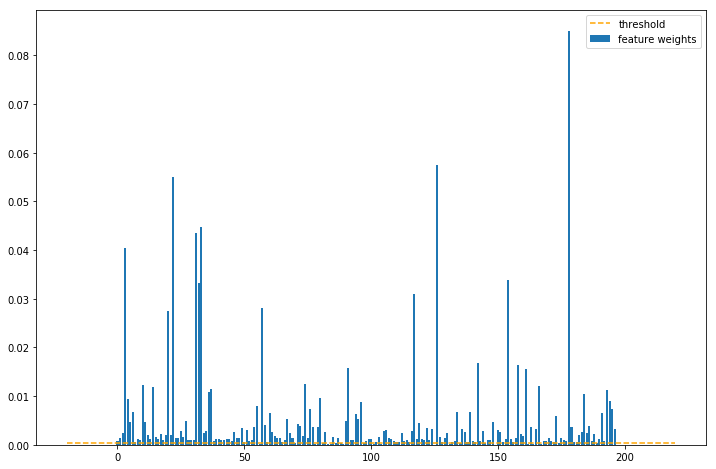

In [46]:
# Plot feature importances and threshold

plt.figure(figsize = (12,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.hlines(threshold, -20, 220, colors="orange", linestyles="dashed")
plt.legend(("threshold", "feature weights"))

In [47]:
# Set training and test dataframes

y_train = train["SalePrice"]
X_train = train.drop(columns = 'SalePrice')
X_test = test.copy()

In [48]:
# Select features using threshold

selection = SelectFromModel(model, threshold=threshold, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test  = selection.transform(X_test)

X_train = pd.DataFrame(select_X_train)
X_test = pd.DataFrame(select_X_test)

X_train.shape

(1460, 178)

<center>
    <h2><font color='#77216F'>7. Fitting models</font></h2>
</center>

We are now ready to fit a set of models. In this case, we decided to use: 

* Ridge regression (cross validated with k-fold method, k = 10)
* Lasso regression (cross validated with k-fold method, k = 10)
* Elastic net regression (cross validated with k-fold method, k = 10)
* Gradient Boosting Regressor
* XGBRegressor
* LGBMRegressor
* A stacking model of all the previous models

In [49]:
# Ensemble

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor

RANDOM_SEED = 1869097
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# Ridge regression

ridge = make_pipeline(RobustScaler(), linear_model.RidgeCV(cv=kfolds))   

# Lasso regression

lasso = make_pipeline(RobustScaler(), linear_model.LassoCV(max_iter=1e7, 
                                                           random_state=RANDOM_SEED, cv=kfolds))
# Elastic Net regression

elasticnet = make_pipeline(RobustScaler(), linear_model.ElasticNetCV(max_iter=1e7, cv=kfolds,
                                                                     random_state=RANDOM_SEED))

In [50]:
# Gradient Boosting Regressor

gbr = GradientBoostingRegressor(n_estimators=4000, learning_rate=0.08, max_depth=3,
                                             max_features='sqrt', min_samples_leaf=18, min_samples_split=14, 
                                             loss='huber', random_state=RANDOM_SEED)                             

gbr = make_pipeline(RobustScaler(), gbr)

In [51]:
# XGBRegressor

xgbr = XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=4000, 
                         objective='reg:linear', booster='gbtree', n_jobs=1, 
                         gamma=0, min_child_weight=0, max_delta_step=0, subsample=.8, colsample_bytree=.8, 
                         reg_alpha=0.0005, scale_pos_weight=1, random_state = RANDOM_SEED)


xgbr = make_pipeline(RobustScaler(), xgbr)

In [52]:
# LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', num_leaves=3,learning_rate=0.05, n_estimators=4000, max_bin=215)

lightgbm = make_pipeline(RobustScaler(), lightgbm)

In [53]:
# Stacking model

rf = RandomForestRegressor(random_state = RANDOM_SEED)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgbr, lightgbm),
                                meta_regressor=rf,
                                cv = kfolds,
                                use_features_in_secondary=True)

In [54]:
# Training models

print('stack_gen...', end=" ")
stack_model = stack_gen.fit(np.array(X_train), np.array(y_train))
print("done")

print('elasticnet...', end=" ")
elastic_model = elasticnet.fit(X_train, y_train)
print("done")

print('Lasso...', end=" ")
lasso_model = lasso.fit(X_train, y_train)
print("done")

print('Ridge...', end=" ")
ridge_model = ridge.fit(X_train, y_train)
print("done")

print('GradientBoosting...', end=" ")
grb_model = gbr.fit(X_train, y_train)
print("done")

print('xgboost...', end=" ")
xgb_model = xgbr.fit(X_train, y_train)
print("done")

print('lightbmRegressor...', end=" ")
lightgbm_model = lightgbm.fit(X_train, y_train)
print("done")

stack_gen... done
elasticnet... done
Lasso... done
Ridge... done
GradientBoosting... done
xgboost... done
lightbmRegressor... done


<center>
    <h2><font color='#77216F'>8. Prediction</font></h2>
</center>

We make now a weighted sum of all the model predictions.

In [55]:
# First prediction

y_pred = 0.2 * ridge_model.predict(X_test) + 0.05* lasso_model.predict(X_test) + \
         0.1 * grb_model.predict(X_test)  + 0.1 * elastic_model.predict(X_test) + \
         0.2 * xgb_model.predict(X_test) + 0.05 * lightgbm_model.predict(X_test) + \
         0.3 * stack_gen.predict(np.matrix(X_test))
y_pred = np.exp(y_pred)

In [56]:
y_pred

array([122283.93243542, 158815.13967402, 185166.05914998, ...,
       165003.14358336, 114453.13554764, 221004.2319401 ])

In [61]:
y_pred = pd.concat([test_id, pd.DataFrame(y_pred, columns = ["SalePrice"])], axis = 1)
print('written at', datetime.datetime.now())
y_pred.head()

written at 2019-08-07 19:35:59.762109


,Id,SalePrice
0,1461,122283.932435
1,1462,158815.139674
2,1463,185166.059150
3,1464,197166.037745
4,1465,188675.969209


Quantile adjustment: we perform a quantile adjustment for the lowest and highest values in our prediction.

In [62]:
# Lower and upper thresholds

lower = y_pred.SalePrice.quantile(0.005)
upper = y_pred.SalePrice.quantile(0.98)
print(lower, upper)

57044.71567668363 397545.41336086503


In [63]:
# Update prediction

y_new_pred = y_pred.copy()
y_new_pred.SalePrice = y_new_pred.SalePrice.apply(lambda x: x*1.15 if x > upper else x)
y_new_pred.SalePrice = y_new_pred.SalePrice.apply(lambda x: x*0.70 if x < lower else x)

# Write prediction to submission file

y_new_pred.to_csv("dataset/submission.csv", index = False)
y_new_pred.head()

,Id,SalePrice
0,1461,122283.932435
1,1462,158815.139674
2,1463,185166.059150
3,1464,197166.037745
4,1465,188675.969209
